In [169]:
import scanpy as sc
import anndata
import numpy as np
import seaborn as sns
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import tifffile
from skimage.exposure import rescale_intensity
from skimage.feature import peak_local_max
from skimage import img_as_float, img_as_ubyte
from statannot import add_stat_annotation

import pandas as pd
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
import pickle
import os

In [170]:
adata = anndata.read_h5ad(filename=r'..\results\HCH\patches\hch_006_7 clustered data.h5ad')
regions = pd.read_pickle(r'..\results\HCH\patches\hch_006_7 subcellular neighborhood.pkl')

In [171]:
adata

AnnData object with n_obs × n_vars = 5883 × 2
    obs: 'leiden'
    uns: 'leiden', 'neighbors'
    obsm: 'spatial'
    obsp: 'connectivities', 'distances'

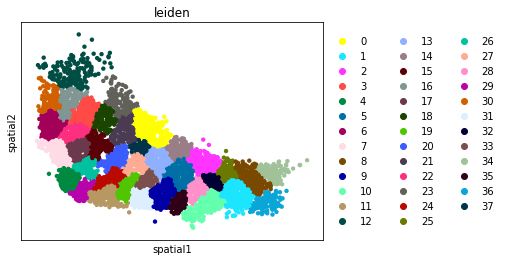

In [172]:
sc.pl.spatial(adata, color='leiden', spot_size=10)

In [173]:
temp = tifffile.imread(r'..\images\HCH\registered\006\cycle7_ConA_PhA_WGA_006.tif')
cona = temp[:,:,:,1]
cona = cona.reshape(cona.shape[1], cona.shape[2])
cona = rescale_intensity(cona)
wga = temp[:,:,:,3]
wga = wga.reshape(wga.shape[1], wga.shape[2])
wga = rescale_intensity(wga)

In [174]:
print(cona.shape)
print(wga.shape)

(2182, 2108)
(2182, 2108)


# Extract subcellular region expression level of cona and wga

In [175]:
adata

AnnData object with n_obs × n_vars = 5883 × 2
    obs: 'leiden'
    uns: 'leiden', 'neighbors', 'leiden_colors'
    obsm: 'spatial'
    obsp: 'connectivities', 'distances'

In [176]:
neighborhoods = adata.obs['leiden']
spatial = adata.obsm['spatial']

In [179]:
cona_exp = np.zeros(38)
wga_exp = np.zeros(38)
for i in tqdm(range(spatial.shape[0])):
    neighbor = int(neighborhoods[i])
    sp = spatial[i,:]
    mask = np.zeros(wga.shape)
    for j in range(sp[0]-3, sp[0]+3):
        for k in range(sp[1]-3, sp[1]+3):
            mask[j,k] = 1
    cona_exp[neighbor] = cona_exp[neighbor] + np.sum(mask*cona)
    wga_exp[neighbor] = wga_exp[neighbor] + np.sum(mask*wga)

100%|██████████████████████████████████████████████████████████████████████████████| 5883/5883 [04:41<00:00, 20.92it/s]


In [180]:
region_exp = regions['expression']

In [186]:
region_exp

,EEF2,ACTB,SOX9,GAPDH,SPP1,IL8,IL6,CCL11,COL5A2,COL1A1,PDL1,MALAT1,RUNX1,CXCR4,MKI67,NANOG
0,32.0,54.0,1.0,41.0,1.0,3.0,18.0,0.0,23.0,66.0,0.0,0.0,0.0,2.0,3.0,1.0
1,44.0,87.0,2.0,67.0,3.0,0.0,31.0,0.0,7.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,41.0,75.0,4.0,52.0,1.0,2.0,24.0,0.0,10.0,9.0,0.0,0.0,0.0,2.0,3.0,0.0
3,18.0,59.0,3.0,27.0,1.0,0.0,9.0,0.0,26.0,60.0,0.0,0.0,0.0,0.0,3.0,0.0
4,26.0,59.0,2.0,60.0,0.0,0.0,38.0,0.0,3.0,4.0,1.0,4.0,0.0,0.0,0.0,0.0
5,25.0,52.0,2.0,27.0,1.0,0.0,13.0,0.0,29.0,46.0,1.0,0.0,0.0,0.0,1.0,0.0
6,18.0,76.0,0.0,38.0,0.0,0.0,16.0,0.0,13.0,33.0,0.0,0.0,0.0,0.0,2.0,0.0
7,23.0,64.0,0.0,53.0,1.0,2.0,23.0,1.0,5.0,18.0,0.0,0.0,0.0,1.0,2.0,0.0
8,33.0,70.0,0.0,62.0,0.0,0.0,23.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
9,21.0,45.0,1.0,32.0,0.0,0.0,12.0,0.0,25.0,53.0,0.0,0.0,0.0,0.0,2.0,1.0


In [181]:
total_exp = np.array(region_exp.sum(axis=1).tolist())

In [182]:
wga_exp = wga_exp/(1e6*total_exp)

In [183]:
cona_exp = cona_exp/(1e6*total_exp)

In [188]:
region_exp['WGA'] = wga_exp.tolist()
region_exp['ConA'] = cona_exp.tolist()

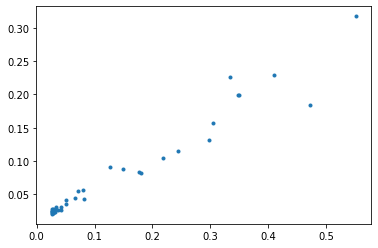

In [189]:
plt.plot(region_exp['WGA'], region_exp['ConA'], '.')

In [190]:
region_corr = region_exp.corr(method='pearson')

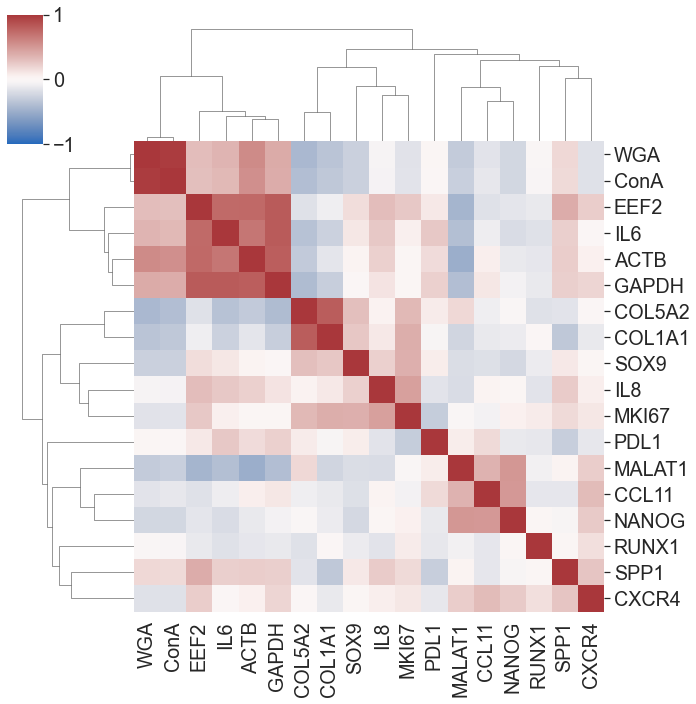

In [191]:
sns.set(font_scale=1.8)
sns.clustermap(region_corr, cmap='vlag', vmin=-1, vmax=1)
# plt.savefig('protein rna subcellular region correlation_v3.png')

In [192]:
def proximity_network(cluster_rna_df, n_neighbors, cona, wga):
    r = cluster_rna_df['row'].tolist()
    c = cluster_rna_df['column'].tolist()
    r_c = list(zip(r,c))
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(r_c)
    dist, neighbors = neigh.kneighbors(r_c)
    
    genes = cluster_rna_df['gene'].tolist()
    markers_l = list(np.unique(genes))
    counts = np.zeros((cluster_rna_df.shape[0], len(markers_l)+2))
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            neighbor = neighbors[i,j]
            idx = markers_l.index(genes[neighbor])
            counts[i,idx] = counts[i,idx] + 1
            (row, col) = r_c[neighbor]
            counts[i,len(markers_l)] = counts[i,len(markers_l)] + cona[row,col]
            counts[i,len(markers_l)+1] = counts[i,len(markers_l)+1]+wga[row,col]
    df = pd.DataFrame(counts, columns=markers_l+['CONA', 'WGA'])
    return df.corr(method='pearson')

In [193]:
# Load dot locations
fn = r'..\results\HCH\detected_dots\hch_006_7.pkl'
cell = pd.read_pickle(fn)

In [194]:
neighborhood = adata.obs['leiden'].tolist()
neighborhood = [int(item) for item in neighborhood]

In [195]:
new_dic = {}
for k in cell.keys():
    df = pd.DataFrame(cell[k])
    df.columns = ['row', 'column']
    df['cluster'] = neighborhood[:df.shape[0]]
    neighborhood = neighborhood[df.shape[0]:]
    new_dic[k] = df

In [196]:
df = None
for k in new_dic.keys():
    if df is None:
        t = new_dic[k]
        t['gene'] = [k]*t.shape[0]
        df = t
    else:
        t = new_dic[k]
        t['gene'] = [k]*t.shape[0]
        df = pd.concat([df, t])

In [197]:
n_clusters = len(np.unique(adata.obs['leiden'].tolist()))
rna_neighbor_exp = np.zeros((n_clusters, 16))
i = 0
markers_l = []
for k in new_dic.keys():
    for j in range(n_clusters):
         rna_neighbor_exp[j,i] = sum(item==j for item in new_dic[k]['cluster'].tolist())
    i = i + 1

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [198]:
corr_l = []
for i in range(n_clusters):
    corr_l.append(proximity_network(df.loc[df['cluster']==i], n_neighbors=10, cona=cona, wga=wga))

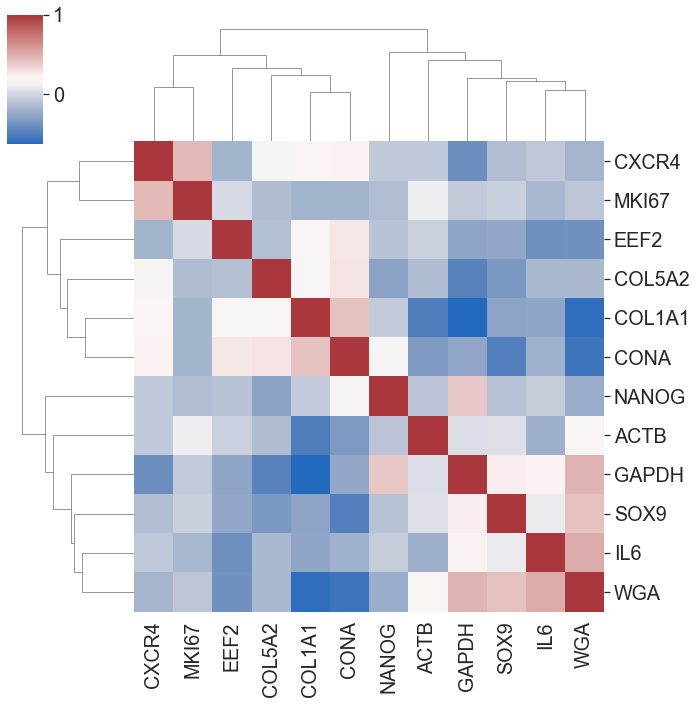

In [199]:
sns.clustermap(corr_l[18], cmap='vlag')

In [200]:
out_dir = r'..\results\HCH\rna_protein_network\006-7'

In [201]:
with open(os.path.join(out_dir, 'hch_006_06_30neighborhoods_10_neighbors_v2.pkl'), 'wb') as f:
    pickle.dump(corr_l, f)

In [202]:
z_score_df = (region_exp - region_exp.mean())/(region_exp.std())

In [203]:
exp_l = [region_exp, z_score_df]

In [204]:
with open(os.path.join(out_dir, 'hch_006_07_37neighborhoods_z-score_expression.pkl'), 'wb') as f:
    pickle.dump(exp_l, f)

## Batch RNA-protein network analysis

In [ ]:
in_dir = r''

adata = anndata.read_h5ad(filename=r'..\results\HCH\neighborhood_networks\hch_006_7 clustered data.h5ad')
regions = pd.read_pickle(r'..\results\HCH\neighborhood_networks\hch_006_7 subcellular neighborhood.pkl')

## RNA-protein statistics

In [118]:
cona_thre_dir = r'..\images\HCH\colocalization_analysis\ConA_col1a1\threshold'
cona_im_dir = r'..\images\HCH\colocalization_analysis\ConA_col1a1\images'
cona_cell_dir = r'..\images\HCH\colocalization_analysis\ConA_col1a1\cell'

cona_thre_mask = []
fn_l = os.listdir(cona_thre_dir)
fn_l.sort()
for fn in fn_l:
    cona_thre_mask.append((tifffile.imread(os.path.join(cona_thre_dir, fn))>0).astype('float'))

cona_ims = []
fn_l = os.listdir(cona_im_dir)
fn_l.sort()
for fn in fn_l:
    cona_ims.append(tifffile.imread(os.path.join(cona_im_dir, fn))[0,:,:])

cona_mask = []
fn_l = os.listdir(cona_cell_dir)
fn_l.sort()
for fn in fn_l:
   cona_mask.append((tifffile.imread(os.path.join(cona_cell_dir, fn))>0).astype('float'))

In [119]:
wga_thre_dir = r'..\images\HCH\colocalization_analysis\wga_col1a1\threshold'
wga_im_dir = r'..\images\HCH\colocalization_analysis\wga_col1a1\image'
wga_cell_dir = r'..\images\HCH\colocalization_analysis\wga_col1a1\cell'

wga_thre_mask = []
fn_l = os.listdir(wga_thre_dir)
fn_l.sort()
for fn in fn_l:
    wga_thre_mask.append((tifffile.imread(os.path.join(wga_thre_dir, fn))>0).astype('float'))

wga_ims = []
fn_l = os.listdir(wga_im_dir)
fn_l.sort()
for fn in fn_l:
    wga_ims.append(tifffile.imread(os.path.join(wga_im_dir, fn))[0,:,:])
    
wga_mask = []
fn_l = os.listdir(wga_cell_dir)
fn_l.sort()
for fn in fn_l:
    wga_mask.append((tifffile.imread(os.path.join(wga_cell_dir, fn))>0).astype('float'))

In [53]:
# Extract pixels
staining = []
marker = []
pixel_intensity = []
for k in range(len(cona_ims)):
    im = cona_ims[k]
    cona_thre = cona_thre_mask[k]
    cell = cona_mask[k]
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if cell[i,j] > 0:
                pixel_intensity.append(im[i,j].astype('float'))
                marker.append('ConA')
                if cona_thre[i,j] > 0:
                    staining.append('Positive')
                else:
                    staining.append('Negative')

for k in range(len(wga_ims)):
    im = wga_ims[k]
    wga_thre = wga_thre_mask[k]
    cell = wga_mask[k]
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if cell[i,j] > 0:
                pixel_intensity.append(im[i,j].astype('float'))
                marker.append('WGA')
                if wga_thre[i,j] > 0:
                    staining.append('Positive')
                else:
                    staining.append('Negative')

In [56]:
# Make dataframe from list
df = pd.DataFrame({'COL1A1 Intensity': pixel_intensity, 'Marker': marker, 'Staining': staining})
# df.min()

In [57]:
df

,COL1A1 Intensity,Marker,Staining
0,1672.0,ConA,Negative
1,1660.0,ConA,Negative
2,1595.0,ConA,Negative
3,1779.0,ConA,Negative
4,1656.0,ConA,Negative
...,...,...,...
310769,117.0,WGA,Negative
310770,0.0,WGA,Negative
310771,0.0,WGA,Negative
310772,27.0,WGA,Negative


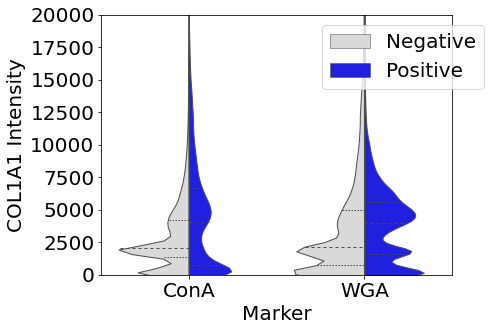

In [81]:
with rc_context({'font.size':20, 'figure.figsize':(7,5)}):
    sns.violinplot(data=df, x="Marker", y="COL1A1 Intensity", hue="Staining",
                   split=True, inner="quart", linewidth=1,
                   palette={"Positive": "b", "Negative": ".85"})
    plt.ylim(-5,20000)
    plt.legend(bbox_to_anchor=(0.6,1), loc='upper left')
    plt.tight_layout()
    plt.savefig('.\\figures\\rna_protein\\ConA wga.png')

<AxesSubplot:xlabel='Marker', ylabel='COL1A1 Intensity'>

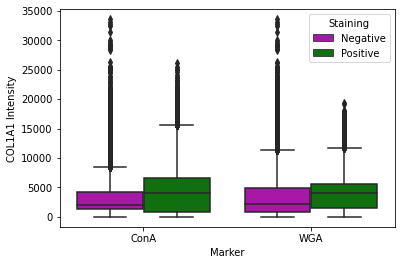

In [60]:
sns.boxplot(x="Marker", y="COL1A1 Intensity",
            hue="Staining", palette=["m", "g"],
            data=df)

### Numer of dots in ConA and WGA+ regions

In [83]:
# Load adjusted images
adjusted_col1a1 = []
adjusted_dir = r'..\images\HCH\colocalization_analysis\adjusted_col1a1'
fn_l = os.listdir(adjusted_dir)
fn_l.sort()
for fn in fn_l:
    adjusted_col1a1.append(tifffile.imread(os.path.join(adjusted_dir, fn)))

In [105]:
col1a1_l = []

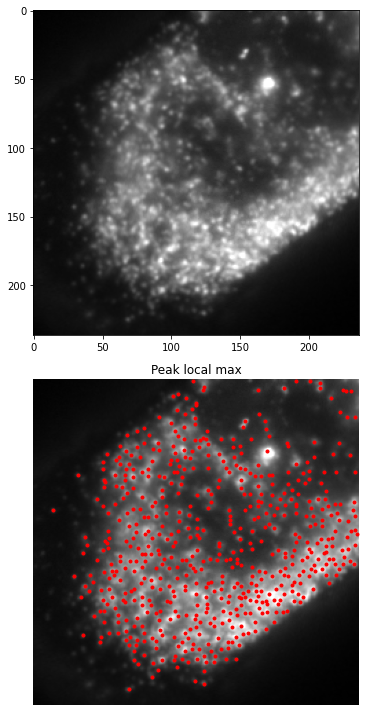

In [106]:
# Dot detection of the 3 images
im = img_as_float(cona_ims[0])

coordinates = peak_local_max(im, threshold_rel=0.15)

im_adjusted = adjusted_col1a1[0]
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(im_adjusted, cmap=plt.cm.gray)
ax[0].autoscale(False)

ax[1].imshow(im_adjusted, cmap=plt.cm.gray)
ax[1].autoscale(False)
ax[1].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].axis('off')
ax[1].set_title('Peak local max')
fig.tight_layout()

plt.show()
col1a1_l.append(coordinates)

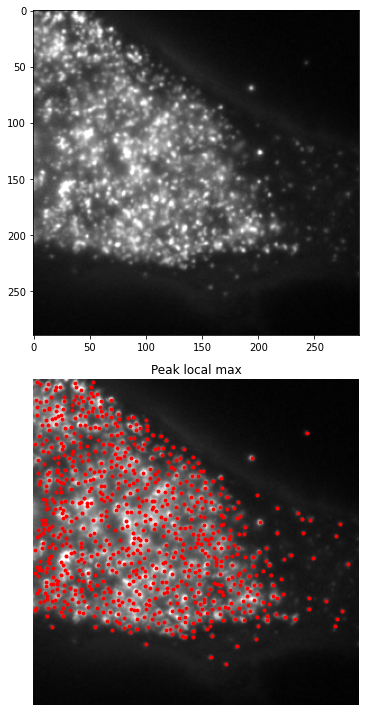

In [107]:
im = img_as_float(cona_ims[1])

coordinates = peak_local_max(im, threshold_rel=0.15)

im_adjusted = adjusted_col1a1[1]
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(im_adjusted, cmap=plt.cm.gray)
ax[0].autoscale(False)

ax[1].imshow(im_adjusted, cmap=plt.cm.gray)
ax[1].autoscale(False)
ax[1].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].axis('off')
ax[1].set_title('Peak local max')
fig.tight_layout()

plt.show()
col1a1_l.append(coordinates)

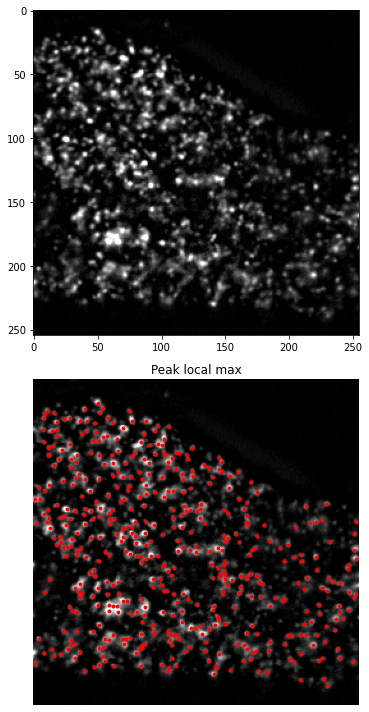

In [108]:
im = img_as_float(cona_ims[2])

coordinates = peak_local_max(im, threshold_rel=0.15)

im_adjusted = adjusted_col1a1[2]
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
ax = axes.ravel()

ax[0].imshow(im_adjusted, cmap=plt.cm.gray)
ax[0].autoscale(False)

ax[1].imshow(im_adjusted, cmap=plt.cm.gray)
ax[1].autoscale(False)
ax[1].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].axis('off')
ax[1].set_title('Peak local max')
fig.tight_layout()

plt.show()
col1a1_l.append(coordinates)

In [110]:
col1a1_l[0].shape

(584, 2)

In [120]:
# Count dots inside cona region and wga region
cona_pos_count = [0,0,0]
cona_neg_count = [0,0,0]
wga_pos_count = [0,0,0]
wga_neg_count = [0,0,0]

cona_pos_area = [0,0,0]
wga_pos_area = [0,0,0]

cona_pos_prop = [0,0,0]
wga_pos_prop = [0,0,0]

for k in range(3):
    coor = col1a1_l[k]
    wga = wga_thre_mask[k]
    cona = cona_thre_mask[k]
    mask = cona_mask[k]
    for idx in range(coor.shape[0]):
        i = coor[idx, 0]
        j = coor[idx, 1]
        if cona[i,j]>0:
            cona_pos_count[k] = cona_pos_count[k] + 1
        elif mask[i,j] > 0:
            cona_neg_count[k] = cona_neg_count[k] + 1
        if wga[i,j] > 0:
            wga_pos_count[k] = wga_pos_count[k] + 1
        elif mask[i,j] > 0:
            wga_neg_count[k] = wga_neg_count[k] + 1
    cona_pos_area[k] = np.sum(cona)/np.sum(mask)
    wga_pos_area[k] = np.sum(wga)/np.sum(mask)
    
    cona_pos_prop[k] = cona_pos_count[k]/(cona_pos_count[k]+cona_neg_count[k])
    wga_pos_prop[k] = wga_pos_count[k]/(wga_pos_count[k]+wga_neg_count[k])

In [134]:
cona_enrich = [cona_pos_prop[0]/cona_pos_area[0], cona_pos_prop[1]/cona_pos_area[1], cona_pos_prop[2]/cona_pos_area[2]]
cona_enrich

[1.7961330147534293, 1.390058496884839, 1.1658095564188442]

In [135]:
wga_enrich = [wga_pos_prop[0]/wga_pos_area[0], wga_pos_prop[1]/wga_pos_area[1], wga_pos_prop[2]/wga_pos_area[2]]
wga_enrich

[1.3775051048695723, 1.0691416386685855, 0.9820348827643296]

In [130]:
marker = ['ConA']*3+['WGA']*3
proportion = cona_pos_area + cona_pos_prop + wga_pos_area + wga_pos_prop
hue = (['Marker Area']*3+['Count Proportion']*3)*2
data = pd.DataFrame({'Marker': marker, 'Proportion': proportion, 'Hue': hue})

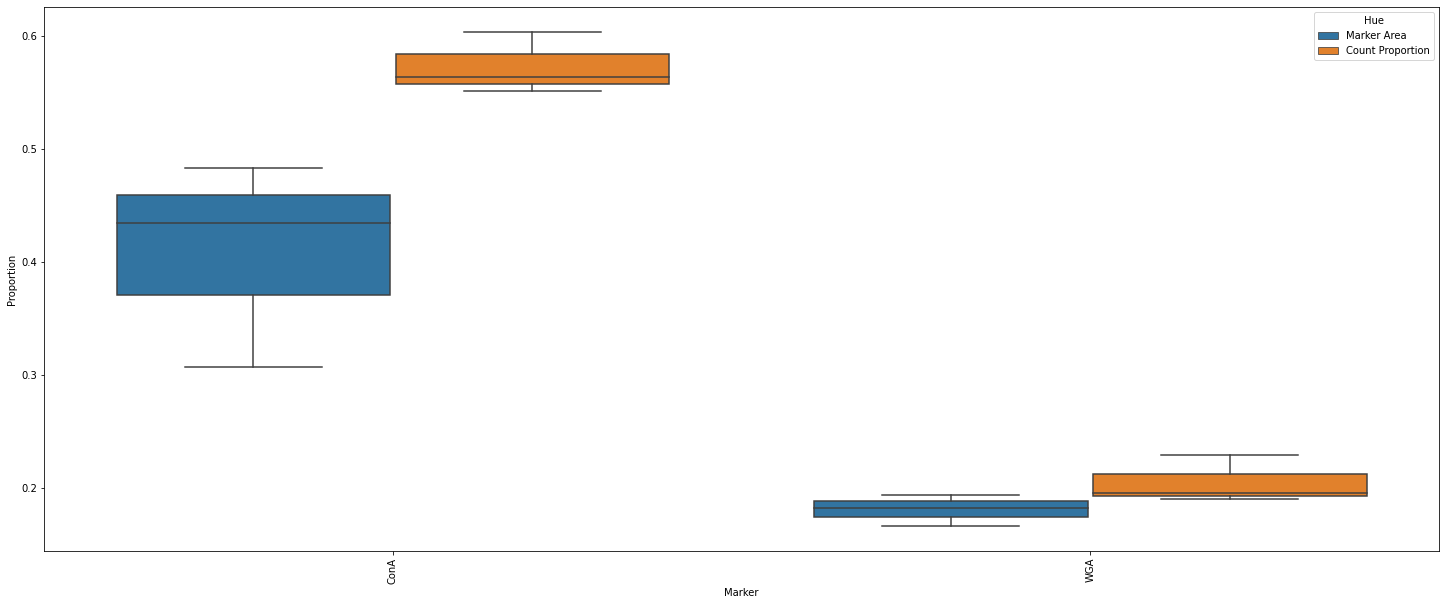

In [132]:
channel_pairs = data["Marker"].unique()
hue = "Hue"
x = "Marker"
y = "Proportion"
hue_order=["Marker Area", 'Count Proportion']
plt.figure(figsize=(25, 10))
# plt.title('PC1 biased Pearson\'s correlation between markers')

box_pairs=[((chan, "Marker Area"), (chan, "Count Proportion")) for chan in channel_pairs]

g = sns.boxplot(data=data, hue=hue, x=x, y=y) 
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
"""
add_stat_annotation(g, data=combined, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction =None)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 30, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 30)
g.set_title(f'PC1 biased Pearson\'s correlation between markers',fontsize= 30, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("Pairwise correlation",fontsize=25)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Cell Type', fontsize=25, title_fontsize=25, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig('bm uc hch pc1 correlation.png', bbox_inches="tight")
"""
plt.show()

In [250]:
enrichment_df = pd.DataFrame({'Markers': ['COL1A1-ConA']*3+['COL1A1-WGA']*3, 'Enrichment': cona_enrich+wga_enrich, 'x': [0]*6})
enrichment_df

,Markers,Enrichment,x
0,COL1A1-ConA,1.796133,0
1,COL1A1-ConA,1.390058,0
2,COL1A1-ConA,1.165810,0
3,COL1A1-WGA,1.377505,0
4,COL1A1-WGA,1.069142,0
5,COL1A1-WGA,0.982035,0


C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


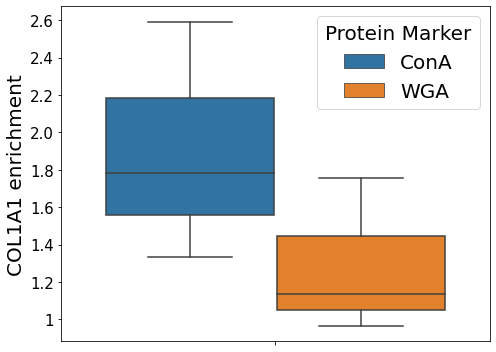

In [168]:
channel_pairs = enrichment_df["x"].unique()
hue = "Markers"
x = 'x'
y = "Enrichment"
hue_order=["ConA", 'WGA']
plt.figure(figsize=(7, 5))
# plt.title('PC1 biased Pearson\'s correlation between markers')

box_pairs=[((chan, "ConA"), (chan, "WGA")) for chan in channel_pairs]

g = sns.boxplot(data=enrichment_df, hue=hue, x=x, y=y) 
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# add_stat_annotation(g, data=enrichment_df, x=x, y=y, hue=hue, box_pairs=box_pairs,
#                     test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction =None)
# g.figure.axes[-1].yaxis.label.set_size(20)
g.set(xticklabels=[])
g.set_yticklabels([0.8,1,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6], fontsize = 15)
# g.set_title(f'PC1 biased Pearson\'s correlation between markers',fontsize= 30, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("COL1A1 enrichment",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='Protein Marker', fontsize=20, title_fontsize=20, loc='best')
plt.tight_layout()
plt.savefig('.\\figures\\rna_protein\\cona_wga_enrichment_comparison.png', bbox_inches="tight")
plt.show()

### Comparison of col1a1-wga and col1a1-cona connection

In [205]:
connectivity1 = pd.read_pickle(r'..\results\HCH\rna_protein_network\006_06\hch_006_06_30neighborhoods_10_neighbors_v2.pkl')
connectivity2 = pd.read_pickle(r'..\results\HCH\rna_protein_network\006_07\hch_006_07_30neighborhoods_10_neighbors_v2.pkl')

In [213]:
col1a1_cona = []
col1a1_wga = []
for item in connectivity1:
    if 'COL1A1' in item.columns.tolist() and 'WGA' in item.columns.tolist():
        col1a1_wga.append(item['COL1A1']['WGA'])
    if 'COL1A1' in item.columns.tolist() and 'CONA' in item.columns.tolist():
        col1a1_cona.append(item['COL1A1']['CONA'])

In [259]:
connectivity_df = pd.DataFrame({'Markers': ['COL1A1-ConA']*len(col1a1_cona)+['COL1A1-WGA']*len(col1a1_wga), 'values': col1a1_cona+col1a1_wga, 'x': [0]*(len(col1a1_cona)+len(col1a1_wga))})

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


AttributeError: 'AxesSubplot' object has no attribute 'legend_off'

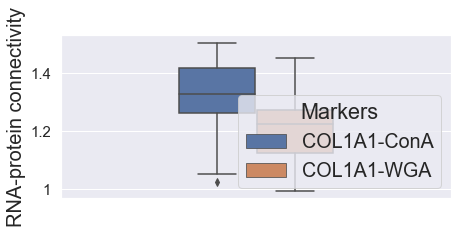

In [263]:
channel_pairs = connectivity_df["x"].unique()
hue = "Markers"
x = 'x'
y = "values"
hue_order=['COL1A1-ConA', 'COL1A1-WGA']
plt.figure(figsize=(7, 3))
# plt.title('PC1 biased Pearson\'s correlation between markers')

box_pairs=[((chan, "COL1A1-ConA"), (chan, "COL1A1-WGA")) for chan in channel_pairs]

g = sns.boxplot(data=connectivity_df, hue=hue, x=x, y=y, width=0.4) 
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# add_stat_annotation(g, data=enrichment_df, x=x, y=y, hue=hue, box_pairs=box_pairs,
#                     test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction =None)
# g.figure.axes[-1].yaxis.label.set_size(20)
g.set(xticklabels=[])
g.set_yticklabels([0.8,1,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6], fontsize = 15)
# g.set_title(f'PC1 biased Pearson\'s correlation between markers',fontsize= 30, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("RNA-protein connectivity",fontsize=20)
handles, labels = g.get_legend_handles_labels()
# g.legend(handles, labels, title='Connection', fontsize=20, title_fontsize=20, loc='best', bbox_to_anchor=(1,1))
g.legend_off()
plt.tight_layout()
# plt.savefig('.\\figures\\rna_protein\\cona_wga_connectivity_comparison.png', bbox_inches="tight")
plt.show()

In [251]:
enrichment_df['x'] = ['Enrichment']*6
connectivity_df['x'] = ['Connectivity']*connectivity_df.shape[0]

In [252]:
connectivity_df.rename(columns={'Connection':'Markers','connectivity': 'values'},inplace=True)
enrichment_df.rename(columns={'Enrichment':'values'},inplace=True)

In [253]:
combined = pd.concat((enrichment_df, connectivity_df))

In [254]:
combined

,Markers,values,x
0,COL1A1-ConA,1.796133,Enrichment
1,COL1A1-ConA,1.390058,Enrichment
2,COL1A1-ConA,1.165810,Enrichment
3,COL1A1-WGA,1.377505,Enrichment
4,COL1A1-WGA,1.069142,Enrichment
5,COL1A1-WGA,0.982035,Enrichment
0,COL1A1-ConA,0.710224,Connectivity
1,COL1A1-ConA,0.659676,Connectivity
2,COL1A1-ConA,0.688240,Connectivity
3,COL1A1-ConA,0.149549,Connectivity


C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


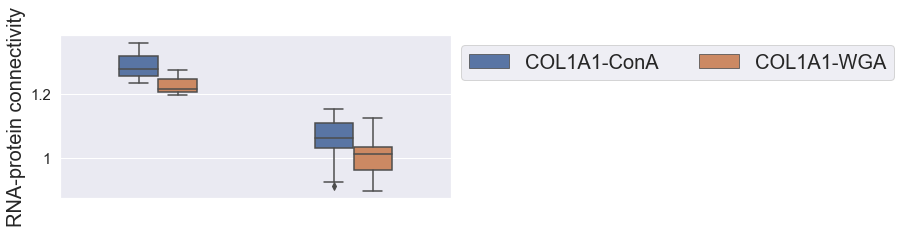

In [284]:
channel_pairs = combined["x"].unique()
hue = "Markers"
x = 'x'
y = "values"
hue_order=['COL1A1-ConA', 'COL1A1-WGA']
plt.figure(figsize=(7, 3))
# plt.title('PC1 biased Pearson\'s correlation between markers')

box_pairs=[((chan, "COL1A1-ConA"), (chan, "COL1A1-WGA")) for chan in channel_pairs]

g = sns.boxplot(data=combined, hue=hue, x=x, y=y, width=0.4) 
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# add_stat_annotation(g, data=enrichment_df, x=x, y=y, hue=hue, box_pairs=box_pairs,
#                     test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction =None)
# g.figure.axes[-1].yaxis.label.set_size(20)
g.set(xticklabels=[])
g.set_yticklabels([0.8,1,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6], fontsize = 15)
# g.set_title(f'PC1 biased Pearson\'s correlation between markers',fontsize= 30, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("RNA-protein connectivity",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, title='', ncol=2, fontsize=20, title_fontsize=20, loc='best', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('.\\figures\\rna_protein\\cona_wga_connectivity_comparison.png', bbox_inches="tight")
plt.show()

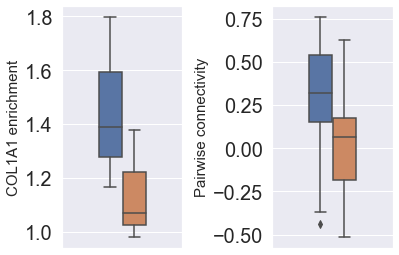

In [282]:
fig, axes = plt.subplots(1, 2)

hue = "Markers"
x = 'x'
y = "values"
hue_order=['COL1A1-ConA', 'COL1A1-WGA']

g1 = sns.boxplot(data=enrichment_df, hue=hue, x=x, y=y, width=0.4, ax=axes[0])
g1.set(xticklabels=[])
g1.set_xlabel("", fontsize=1)
g1.set_ylabel("COL1A1 enrichment", fontsize=15)
g1.legend([],[],frameon=False)

g2 = sns.boxplot(data=connectivity_df, hue=hue, x=x, y=y, width=0.4, ax=axes[1])
g2.set(xticklabels=[])
g2.set_xlabel("", fontsize=1)
g2.set_ylabel("Pairwise connectivity", fontsize=15)
g2.legend([],[],frameon=False)
# handles, labels = g2.get_legend_handles_labels()

# fig.legend(loc='upper left', bbox_to_anchor=(1., 1))

fig.tight_layout()
plt.savefig('.\\figures\\rna_protein_enrichment connectivity.png')